In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys 
import commot as ct

sys.path.append('../../src')
sys.path.append('..')

from spaceoracle.tools.network import expand_paired_interactions
from spaceoracle.tools.network import get_mouse_housekeeping_genes
from spaceoracle.oracles import BaseTravLR
from spaceoracle.tools.network import encode_labels

import celloracle as co

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
adata = sc.read_h5ad(
    '/Users/koush/Downloads/4275b5c3-0141-46c6-b208-e3b3b61271c0.h5ad')
adata

AnnData object with n_obs × n_vars = 24634 × 27554
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'batch', 'seurat_clusters', 'combined_stage', 'combined_state', 'platform', 'assay_ontology_term_id', 'disease_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'donor_id', 'cell_state', 'cell_type_ontology_term_id', 'umap_1', 'umap_2', 'is_primary_data', 'suspension_type', 'self_reported_ethnicity_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'features', 'feature_is_filtered', 'gene_symbols', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'schema_reference', 'schema_version', 'spatial', 'title'
    obsm: 'X_umap', 'spatial'

In [4]:
adata.var_names = adata.var['gene_symbols']

In [5]:
%matplotlib inline

In [6]:
adata = adata[:, ~adata.var_names.str.contains('Rik')]
adata = adata[:, ~adata.var_names.str.contains('rik')]
adata = adata[:, ~adata.var_names.str.contains(r'^Hb\w+-\w+$')]
adata = adata[:, ~adata.var_names.str.contains('Hp')]
adata = adata[:, ~adata.var_names.str.startswith('Rp')]
adata = adata[:, ~adata.var_names.str.startswith('n-r5s')]
adata = adata[:, ~adata.var_names.str.startswith('n-r5')]
adata = adata[:, ~adata.var_names.str.startswith('n-R5s')]
adata = adata[:, ~adata.var_names.str.startswith('n-R5')]
adata = adata[:, ~adata.var_names.str.startswith('n-R5s')]
adata = adata[:, ~adata.var_names.str.startswith('n-R5')]
adata = adata[:, ~adata.var_names.str.startswith('Aa')]
adata = adata[:, ~adata.var_names.str.startswith('Ab')]
adata = adata[:, ~adata.var_names.str.startswith('Ac')]
adata = adata[:, ~adata.var_names.str.startswith('Mir')]
adata = adata[:, adata.var.index.str.len() > 1]
adata = adata[:, [i for i in adata.var_names if not (i[:2].isupper() and i[:2].isalpha())]]
adata = adata[:, [gene for gene in adata.var_names if not gene[-4:].isdigit()]]

In [7]:
adata

View of AnnData object with n_obs × n_vars = 24634 × 18166
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'batch', 'seurat_clusters', 'combined_stage', 'combined_state', 'platform', 'assay_ontology_term_id', 'disease_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'donor_id', 'cell_state', 'cell_type_ontology_term_id', 'umap_1', 'umap_2', 'is_primary_data', 'suspension_type', 'self_reported_ethnicity_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'features', 'feature_is_filtered', 'gene_symbols', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'schema_reference', 'schema_version', 'spatial', 'title'
    obsm: 'X_umap', 'spatial'

In [15]:
adata.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'batch', 'seurat_clusters',
       'combined_stage', 'combined_state', 'platform',
       'assay_ontology_term_id', 'disease_ontology_term_id',
       'development_stage_ontology_term_id', 'sex_ontology_term_id',
       'organism_ontology_term_id', 'tissue_ontology_term_id', 'donor_id',
       'cell_state', 'cell_type_ontology_term_id', 'umap_1', 'umap_2',
       'is_primary_data', 'suspension_type',
       'self_reported_ethnicity_ontology_term_id', 'tissue_type', 'cell_type',
       'assay', 'disease', 'organism', 'sex', 'tissue',
       'self_reported_ethnicity', 'development_stage', 'observation_joinid'],
      dtype='object')

In [18]:
from spaceoracle.tools.network import get_human_housekeeping_genes

housekeeping_db = get_mouse_housekeeping_genes()

In [19]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
adata = adata[:, ~adata.var["mt"]]
adata = adata[:, ~adata.var_names.isin(housekeeping_db['Gene'].unique())]
adata.layers["normalized_count"] = adata.X.toarray().copy()
adata.layers["raw_count"] = (np.exp(adata.X.toarray())-1).copy()


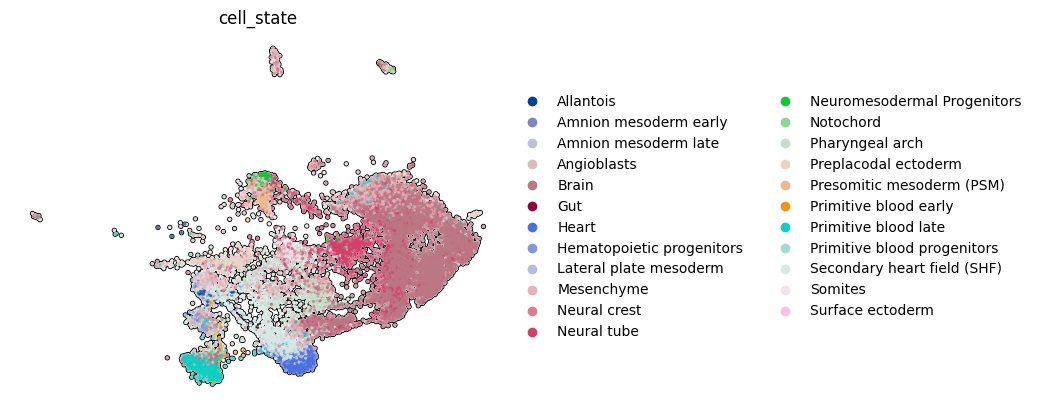

In [ ]:
sc.pl.umap(
    adata, 
    frameon=False, 
    color='cell_state', 
    s=20,
    add_outline=True,
    
)

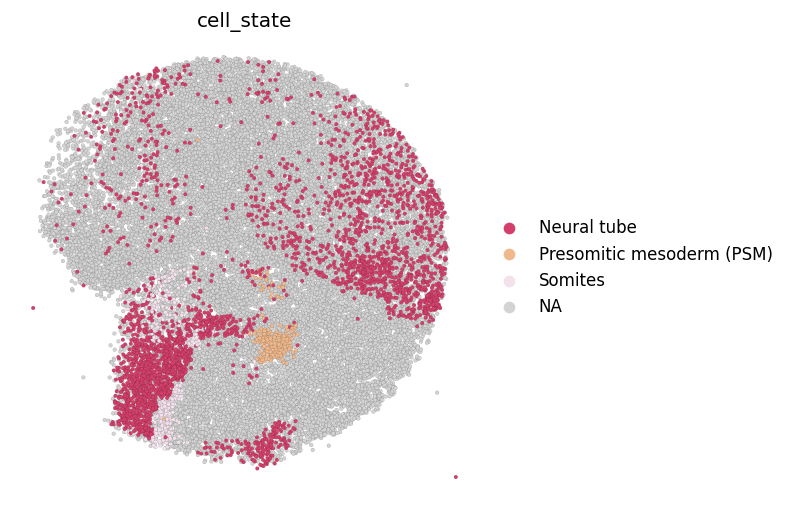

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 120

sc.pl.embedding(
    adata, basis='spatial', 
    frameon=False, color='cell_state',
    groups=['Neural tube', 'Somites', 'Presomitic mesoderm (PSM)'],
    s=20, linewidth=0.05, edgecolor='black' 
)

In [77]:
'Tbx6' in adata[adata.obs.cell_state.isin(['Neural tube', 'Somites'])].var_names

True

In [78]:
del adata.raw

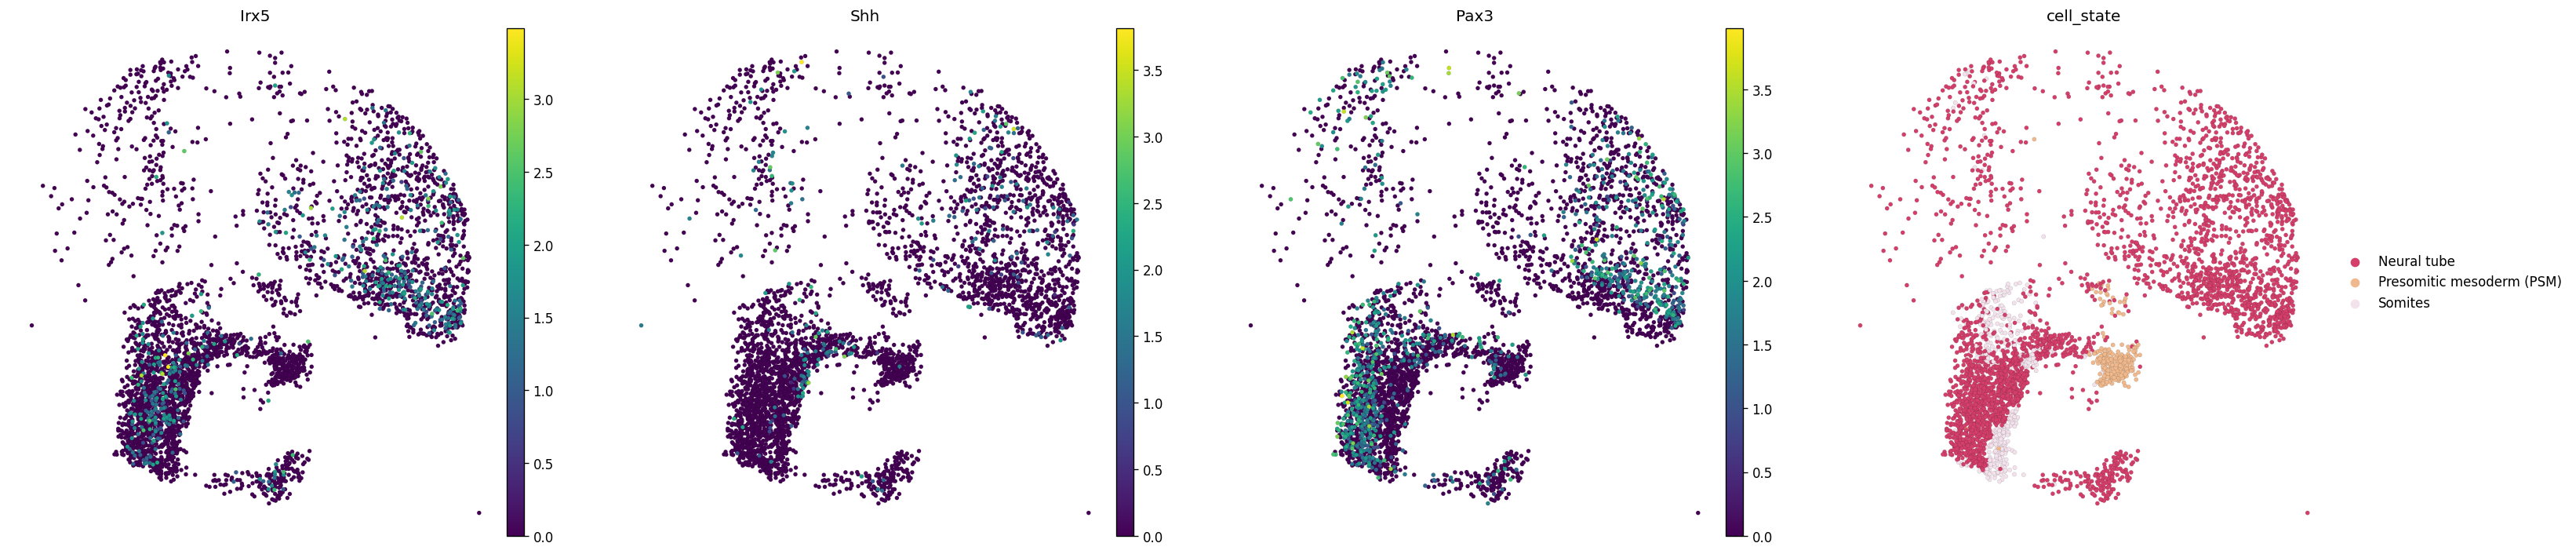

In [79]:
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['figure.dpi'] = 120

sc.pl.embedding(
    adata[adata.obs.cell_state.isin(
        ['Neural tube', 'Somites', 'Presomitic mesoderm (PSM)'])], basis='spatial', 
    frameon=False, color=['Irx5', 'Shh', 'Pax3', 'cell_state'],
    # palette=['pink', 'green'],
    s=40, linewidth=0.05, edgecolor='black' 
)

In [80]:
adata.obsm['X_umap'] = adata.obs[['umap_1', 'umap_2']].values

In [81]:
adata.obs.cell_state.value_counts()

cell_state
Brain                           12254
Neural tube                      2957
Secondary heart field (SHF)      2192
Mesenchyme                       2114
Pharyngeal arch                  1368
Primitive blood late              786
Preplacodal ectoderm              708
Heart                             612
Somites                           401
Presomitic mesoderm (PSM)         237
Angioblasts                       159
Amnion mesoderm early             117
Neuromesodermal Progenitors       113
Amnion mesoderm late              102
Hematopoietic progenitors          86
Primitive blood early              78
Neural crest                       75
Notochord                          75
Allantois                          73
Lateral plate mesoderm             70
Surface ectoderm                   51
Primitive blood progenitors         5
Gut                                 1
Name: count, dtype: int64

In [82]:
adata = adata[adata.obs.cell_state.isin([
        'Brain', 
        'Neural tube', 
        'Secondary heart field (SHF)',
        'Mesenchyme', 
        'Pharyngeal arch', 
        # 'Primitive blood late',
        'Preplacodal ectoderm', 
        'Heart', 
        'Somites',
        'Presomitic mesoderm (PSM)', 
        'Angioblasts',
        'Amnion mesoderm early', 
        'Neuromesodermal Progenitors ',
        'Amnion mesoderm late', 
        # 'Hematopoietic progenitors',
        # 'Primitive blood early', 
        'Neural crest', 
        # 'Notochord', 
        # 'Allantois',
        # 'Lateral plate mesoderm', 
        # 'Surface ectoderm',
        # 'Primitive blood progenitors', 
        # 'Gut'
    ])
]

In [83]:
base_GRN = co.data.load_mouse_promoter_base_GRN()

Loading prebuilt promoter base-GRN. Version: mm10_gimmemotifsv5_fpr2


In [84]:
df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='mouse', 
        signaling_type=None
    )
            
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']
df_ligrec = expand_paired_interactions(df_ligrec)

In [85]:
adata.layers

LayersView with keys: normalized_count, raw_count

In [86]:
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=3000)
adata.X = adata.layers["raw_count"].copy()
adata

AnnData object with n_obs × n_vars = 23409 × 15027
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'batch', 'seurat_clusters', 'combined_stage', 'combined_state', 'platform', 'assay_ontology_term_id', 'disease_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'donor_id', 'cell_state', 'cell_type_ontology_term_id', 'umap_1', 'umap_2', 'is_primary_data', 'suspension_type', 'self_reported_ethnicity_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'features', 'feature_is_filtered', 'gene_symbols', 'feature_name'

In [87]:
sc.pp.filter_genes(adata, min_counts=10)

In [88]:
adata

AnnData object with n_obs × n_vars = 23409 × 12388
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'batch', 'seurat_clusters', 'combined_stage', 'combined_state', 'platform', 'assay_ontology_term_id', 'disease_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'donor_id', 'cell_state', 'cell_type_ontology_term_id', 'umap_1', 'umap_2', 'is_primary_data', 'suspension_type', 'self_reported_ethnicity_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'features', 'feature_is_filtered', 'gene_symbols', 'feature_name'

In [89]:
ligand_receptor_genes = np.intersect1d(
    adata.var_names, 
    df_ligrec.ligand.unique().tolist()+df_ligrec.receptor.unique().tolist())

adata.obs['author_cell_type'] = adata.obs['cell_type'].copy()
adata.obs['cell_type'] = adata.obs['cell_state'].copy()

lr_df = adata.to_df(layer='normalized_count').join(
    adata.obs.cell_type).groupby('cell_type').mean()[
        ligand_receptor_genes].mean().sort_values(ascending=False).to_frame().reset_index()
lr_df.columns = ['genes', 'expr']

In [93]:
lr_df['mean_expr'] = lr_df['genes'].apply(lambda x: adata.to_df(layer='normalized_count')[x].mean())

In [94]:
adata = adata[:, (adata.var.highly_variable | adata.var_names.isin(
    ['Aldh1a2', 'Cdx2', 'Dmbx1', 'Egr2', 'Emx2', 'En1', 'En2', 'Foxa2',
       'Foxd1', 'Foxg1', 'Fzd5', 'Gas1', 'Igf2', 'Irx5', 'Lhx2', 'Mafb',
       'Meox1', 'Mest', 'Nkx6-1', 'Nr2e1', 'Olig2', 'Otx2', 'Pax3',
       'Pax5', 'Pax6', 'Rax', 'Shh', 'Shisa2', 'Sox2', 'Sox3', 'Tbx6',
       'Trh', 'Ttn', 'Vgll3'] + lr_df.query('expr > 0.005').genes.to_list()
))]

adata


View of AnnData object with n_obs × n_vars = 23409 × 3311
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'batch', 'seurat_clusters', 'combined_stage', 'combined_state', 'platform', 'assay_ontology_term_id', 'disease_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'donor_id', 'cell_state', 'cell_type_ontology_term_id', 'umap_1', 'umap_2', 'is_primary_data', 'suspension_type', 'self_reported_ethnicity_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'author_cell_type'
    var: 'features', 'feature_is_filtered', 'ge

In [95]:
%matplotlib inline

In [96]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_int'] = adata.obs['cell_type'].apply(
    lambda x: encode_labels(adata.obs['cell_type'], reverse_dict=True)[x])

In [99]:
adata.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'batch', 'seurat_clusters',
       'combined_stage', 'combined_state', 'platform',
       'assay_ontology_term_id', 'disease_ontology_term_id',
       'development_stage_ontology_term_id', 'sex_ontology_term_id',
       'organism_ontology_term_id', 'tissue_ontology_term_id', 'donor_id',
       'cell_state', 'cell_type_ontology_term_id', 'umap_1', 'umap_2',
       'is_primary_data', 'suspension_type',
       'self_reported_ethnicity_ontology_term_id', 'tissue_type', 'cell_type',
       'assay', 'disease', 'organism', 'sex', 'tissue',
       'self_reported_ethnicity', 'development_stage', 'observation_joinid',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'author_cell_type',
       '

In [100]:
adata.obs = adata.obs[['cell_type', 'cell_type_int', 
    'seurat_clusters', 'umap_1', 'umap_2', 'author_cell_type']]

In [101]:
del adata.uns

In [102]:
adata.var = adata.var.drop(columns=adata.var.columns, inplace=False)

In [103]:
adata

AnnData object with n_obs × n_vars = 23409 × 3311
    obs: 'cell_type', 'cell_type_int', 'seurat_clusters', 'umap_1', 'umap_2', 'author_cell_type'
    obsm: 'X_umap', 'spatial'
    layers: 'normalized_count', 'raw_count'

In [105]:
pcs = BaseTravLR.perform_PCA(adata)

In [106]:
BaseTravLR.knn_imputation(adata, pcs, method='MAGIC')

Calculating MAGIC...
  Running MAGIC on 23409 cells and 3311 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.67 seconds.
    Calculating KNN search...
    Calculated KNN search in 35.84 seconds.
    Calculating affinities...
    Calculated affinities in 33.45 seconds.
  Calculated graph and diffusion operator in 79.01 seconds.
  Calculating imputation...
  Calculated imputation in 2.45 seconds.
Calculated MAGIC in 81.50 seconds.


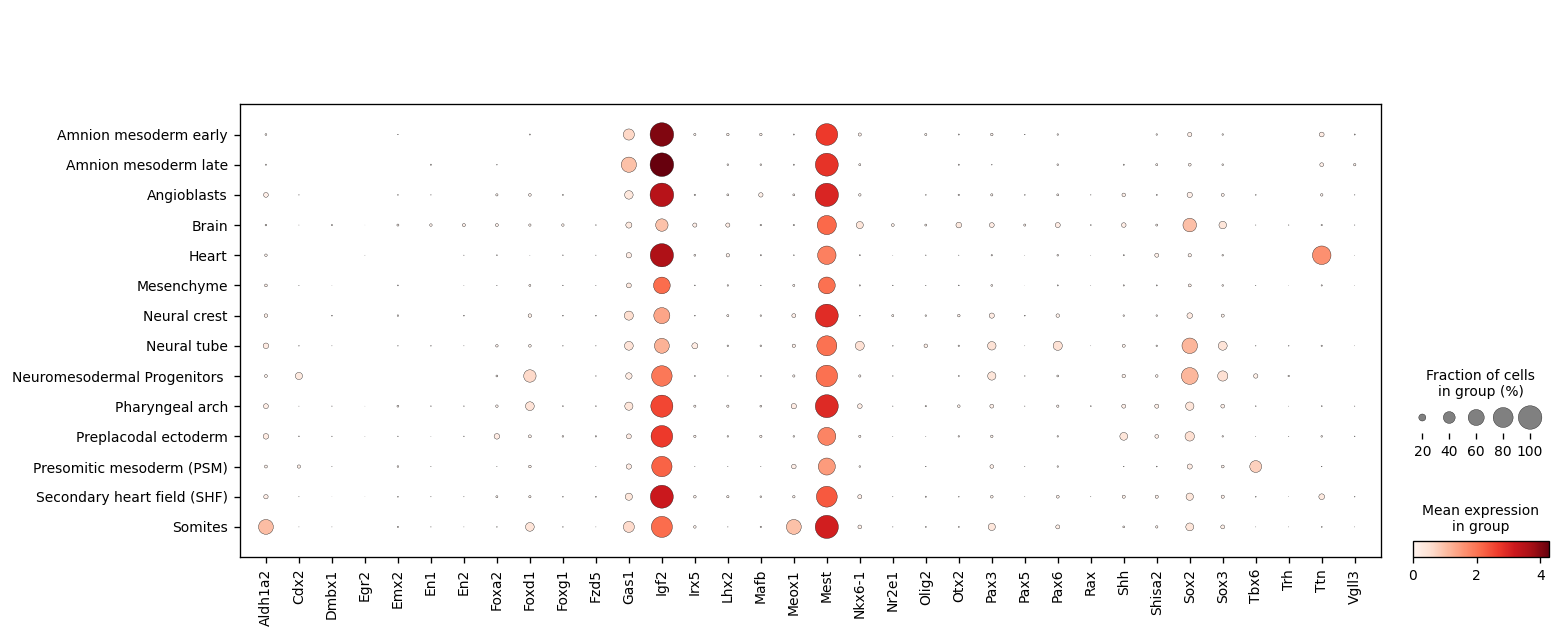

In [108]:
%matplotlib inline
sc.pl.dotplot(
    adata, 
    ['Aldh1a2', 'Cdx2', 'Dmbx1', 'Egr2', 'Emx2', 'En1', 'En2', 'Foxa2',
       'Foxd1', 'Foxg1', 'Fzd5', 'Gas1', 'Igf2', 'Irx5', 'Lhx2', 'Mafb',
       'Meox1', 'Mest', 'Nkx6-1', 'Nr2e1', 'Olig2', 'Otx2', 'Pax3',
       'Pax5', 'Pax6', 'Rax', 'Shh', 'Shisa2', 'Sox2', 'Sox3', 'Tbx6',
       'Trh', 'Ttn', 'Vgll3'], groupby='cell_type', 
    expression_cutoff=0.0,
    layer='normalized_count')
plt.show()

In [109]:
adata.write_h5ad('/Users/koush/Desktop/training_data/mouse_brain_wt_slideseq.h5ad')

# Tbx6 KO

In [29]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/mouse_brain_wt_slideseq.h5ad')
adata

AnnData object with n_obs × n_vars = 23409 × 3311
    obs: 'cell_type', 'cell_type_int', 'seurat_clusters', 'umap_1', 'umap_2', 'author_cell_type'
    uns: 'cell_thresholds', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_umap', 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [34]:
wtko = sc.read_h5ad('/Users/koush/Downloads/mouse_trunkTbx6WT_KO.h5ad')
wtko.var_names = wtko.var['feature_name']
wtko

AnnData object with n_obs × n_vars = 499 × 18945
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'seurat_clusters', 'predicted.id', 'group', 'ko_seurat_clusters', 'proj_AP', 'proj_DV', 'stage', 'cell_state', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'umap_1', 'umap_2', 'is_primary_data', 'suspension_type', 'donor_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'schema_reference', 'schema_version', 

In [35]:
wtko.obs['orig.ident'].value_counts()	

orig.ident
200808_21    309
200703_25    190
Name: count, dtype: int64

In [59]:
wt = wtko[wtko.obs['orig.ident'] == '200703_25']
ko = wtko[wtko.obs['orig.ident'] == '200808_21']
del wt.raw
del ko.raw

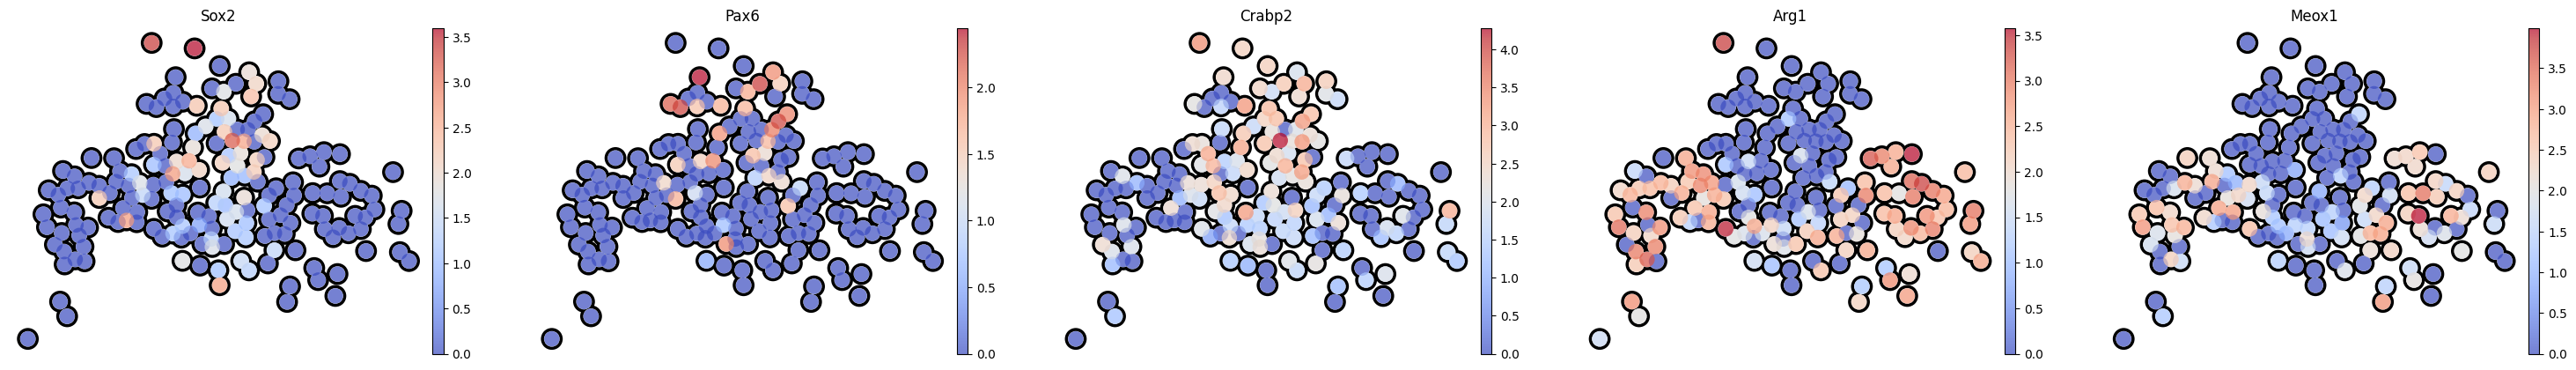

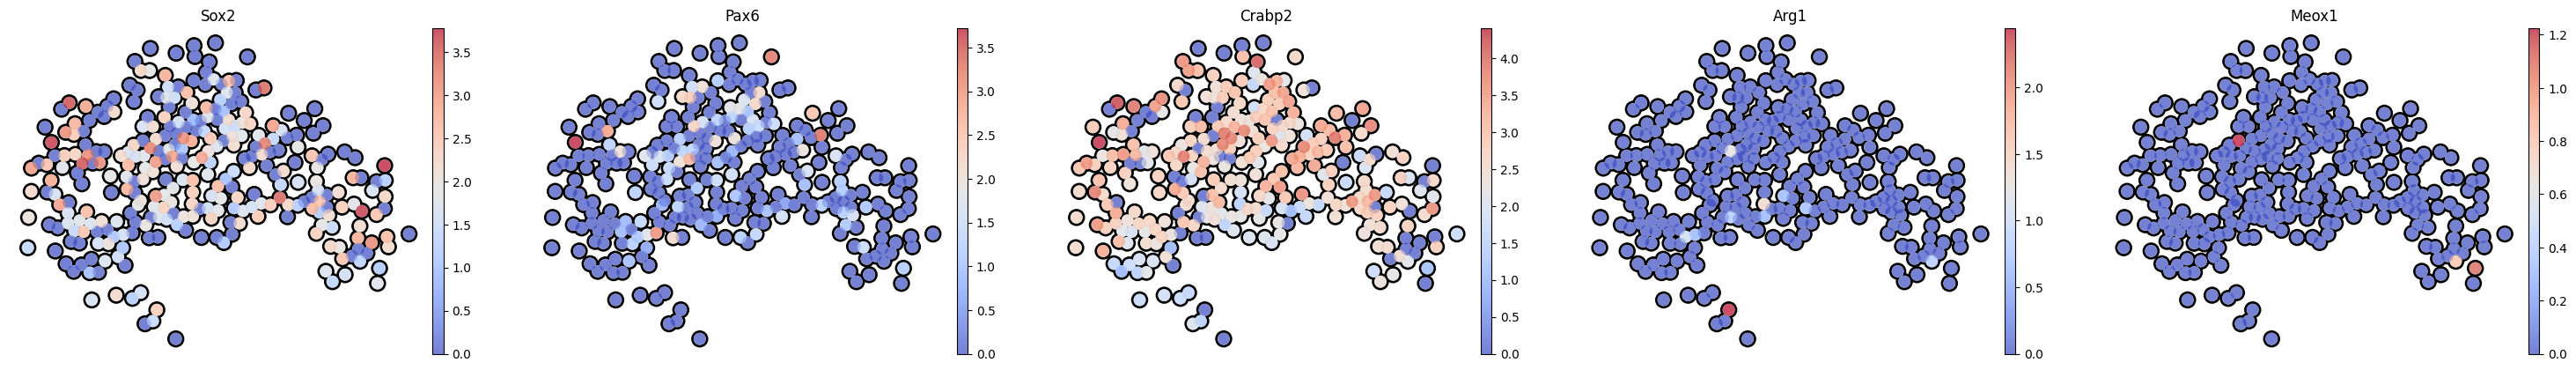

In [93]:
genes = ['Sox2', 'Pax6', 'Crabp2', 'Arg1', 'Meox1']
plot_params = {
    'basis': 'spatial',
    'color': genes,
    'frameon': False,
    'ncols': len(genes),
    'cmap': 'coolwarm',
    'add_outline': True,
    'outline_width': (0.2, 0.01),
    'outline_color': ('black', 'white')
}

for data, label in [(wt, 'WT'), (ko, 'KO')]:
    sc.pl.embedding(data, **plot_params)

plt.show()

In [97]:
wt.obsm['X_umap'] = wt.obs[['umap_1', 'umap_2']].values
ko.obsm['X_umap'] = ko.obs[['umap_1', 'umap_2']].values

In [103]:
wt.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score',
       'G2M.Score', 'Phase', 'seurat_clusters', 'predicted.id', 'group',
       'ko_seurat_clusters', 'proj_AP', 'proj_DV', 'stage', 'cell_state',
       'cell_type_ontology_term_id', 'assay_ontology_term_id',
       'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'sex_ontology_term_id',
       'organism_ontology_term_id', 'tissue_ontology_term_id', 'umap_1',
       'umap_2', 'is_primary_data', 'suspension_type', 'donor_id',
       'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex',
       'tissue', 'self_reported_ethnicity', 'development_stage',
       'observation_joinid'],
      dtype='object')

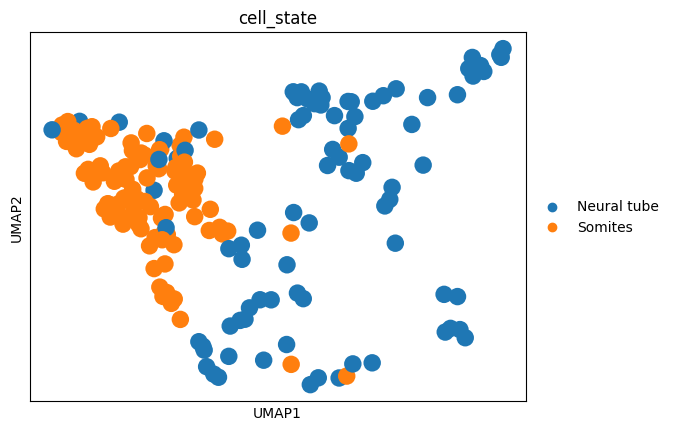

In [107]:
sc.pl.umap(wt, color='cell_state')

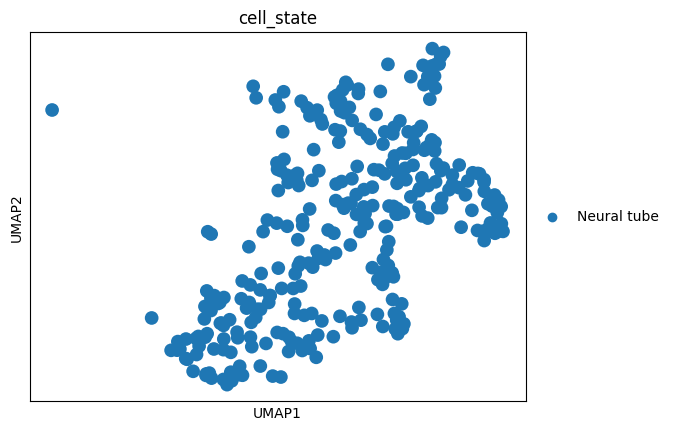

In [111]:
sc.pl.umap(ko, color='cell_state')
